In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


### Test case 1 (parallel conduits, head gradient boundary)

In [56]:
mg = RasterModelGrid((5,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] =  mg.at_link['width'].copy()

#mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(300):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=5.)
    


Number of links =  85
Number of nodes =  50
Number of active links =  43
Number of core nodes =  24
Time iteration: 0
max change in h:  0.181335533358
max change in h:  0.0902838343413
max change in h:  0.0395748690353
max change in h:  0.0152098715574
max change in h:  0.00637771329455
max change in h:  0.0042740871474
max change in h:  0.00260024994417
max change in h:  0.00146292900359
max change in h:  0.000769280563364
max change in h:  0.000380196679112
max change in h:  0.00017690272029
max change in h:  7.73487923577e-05
average dh= 0.085294016877   average abs(dQ)= 0.202734426275
Time iteration: 1
max change in h:  0.343583385743
max change in h:  0.148124138885
max change in h:  0.059786807691
max change in h:  0.0228736364128
max change in h:  0.0122976937021
max change in h:  0.00641867827716
max change in h:  0.00310497844537
max change in h:  0.00139254216036
max change in h:  0.000574944299357
max change in h:  0.000295256938212
max change in h:  0.000178317630583
max ch

max change in h:  0.000926156880265
max change in h:  0.000452580605058
max change in h:  0.000221081172612
max change in h:  0.000107965789747
max change in h:  5.2719267194e-05
average dh= 0.0855354468878   average abs(dQ)= 0.0226109677635
Time iteration: 21
max change in h:  0.0311328789291
max change in h:  0.0153087617243
max change in h:  0.00751150433355
max change in h:  0.0036799569627
max change in h:  0.00180083146622
max change in h:  0.000880531681963
max change in h:  0.000430269005606
max change in h:  0.000210137617033
max change in h:  0.000102577675198
max change in h:  5.00473265728e-05
average dh= 0.0776365831483   average abs(dQ)= 0.0186846912692
Time iteration: 22
max change in h:  0.0295958290327
max change in h:  0.0145551974836
max change in h:  0.00714246022397
max change in h:  0.00349920886338
max change in h:  0.00171220135267
max change in h:  0.000836978338444
max change in h:  0.000408803734876
max change in h:  0.000199521625179
max change in h:  9.7307

max change in h:  0.000972784203417
max change in h:  0.000476064647071
max change in h:  0.000232751597348
max change in h:  0.000113709299351
max change in h:  5.5520286419e-05
average dh= 0.0215234530215   average abs(dQ)= 0.0037236626038
Time iteration: 47
max change in h:  0.0078181039604
max change in h:  0.00384571699346
max change in h:  0.00188754443658
max change in h:  0.000924894267303
max change in h:  0.000452621714832
max change in h:  0.000221288056517
max change in h:  0.000108108326856
max change in h:  5.27854791219e-05
average dh= 0.0204584575493   average abs(dQ)= 0.00353852798452
Time iteration: 48
max change in h:  0.00743343005266
max change in h:  0.0036564562435
max change in h:  0.0017946317291
max change in h:  0.000879358435796
max change in h:  0.000430334244661
max change in h:  0.000210390572422
max change in h:  0.00010278417345
max change in h:  5.01858388313e-05
average dh= 0.0194464407551   average abs(dQ)= 0.00336278108066
Time iteration: 49
max cha

max change in h:  7.7737697449e-05
average dh= 0.00350691805244   average abs(dQ)= 0.000612051843195
Time iteration: 83
max change in h:  0.00127811076525
max change in h:  0.000628578585331
max change in h:  0.000308459799506
max change in h:  0.00015111856877
max change in h:  7.39420000837e-05
average dh= 0.00333567515972   average abs(dQ)= 0.000582325883656
Time iteration: 84
max change in h:  0.00121570041014
max change in h:  0.000597883788
max change in h:  0.000293396564043
max change in h:  0.000143738672327
max change in h:  7.03309359817e-05
average dh= 0.00317275793343   average abs(dQ)= 0.000553986153235
Time iteration: 85
max change in h:  0.00115632747763
max change in h:  0.000568683256946
max change in h:  0.000279066783115
max change in h:  0.000136718175201
max change in h:  6.68957520986e-05
average dh= 0.00301777545122   average abs(dQ)= 0.000526992086265
Time iteration: 86
max change in h:  0.00109984740427
max change in h:  0.000540905708943
max change in h:  0.0

max change in h:  6.63797989837e-05
average dh= 0.000174774912254   average abs(dQ)= 3.19871821194e-05
Time iteration: 148
max change in h:  6.38525849563e-05
average dh= 0.000168123445765   average abs(dQ)= 3.07784381706e-05
Time iteration: 149
max change in h:  6.14208430214e-05
average dh= 0.000161725316512   average abs(dQ)= 2.96137775757e-05
Time iteration: 150
max change in h:  5.90813658343e-05
average dh= 0.000155569399514   average abs(dQ)= 2.84926812881e-05
Time iteration: 151
max change in h:  5.68309168312e-05
average dh= 0.000149645375386   average abs(dQ)= 2.74132686262e-05
Time iteration: 152
max change in h:  5.46662409908e-05
average dh= 0.000143944304125   average abs(dQ)= 2.63733461764e-05
Time iteration: 153
max change in h:  5.25840856209e-05
average dh= 0.000138458485376   average abs(dQ)= 2.53711046114e-05
Time iteration: 154
max change in h:  5.05812376481e-05
average dh= 0.00013318091297   average abs(dQ)= 2.44053420575e-05
Time iteration: 155
max change in h: 

max change in h:  8.89448450891e-07
average dh= 2.34188741331e-06   average abs(dQ)= 4.29183277088e-07
Time iteration: 259
max change in h:  8.55552622525e-07
average dh= 2.25264085265e-06   average abs(dQ)= 4.12827621762e-07
Time iteration: 260
max change in h:  8.22948524437e-07
average dh= 2.16679536977e-06   average abs(dQ)= 3.97095259636e-07
Time iteration: 261
max change in h:  7.91586927562e-07
average dh= 2.08422135398e-06   average abs(dQ)= 3.81962438004e-07
Time iteration: 262
max change in h:  7.61420483997e-07
average dh= 2.00479413387e-06   average abs(dQ)= 3.67406308942e-07
Time iteration: 263
max change in h:  7.32403646175e-07
average dh= 1.92839378905e-06   average abs(dQ)= 3.53404895704e-07
Time iteration: 264
max change in h:  7.04492604697e-07
average dh= 1.8549049692e-06   average abs(dQ)= 3.39937058797e-07
Time iteration: 265
max change in h:  6.77645219938e-07
average dh= 1.78421671976e-06   average abs(dQ)= 3.26982464361e-07
Time iteration: 266
max change in h: 

Node net fluxes =  [  5.32157302e-07   9.87976303e-07   1.30206969e-06   1.42938105e-06
   1.35164808e-06   1.08002213e-06   6.53464883e-07   1.33448543e-07
   5.32157302e-07   9.87976303e-07   1.30206969e-06   1.42938105e-06
   1.35164808e-06   1.08002213e-06   6.53464883e-07   1.33448543e-07
   5.32157302e-07   9.87976303e-07   1.30206969e-06   1.42938105e-06
   1.35164808e-06   1.08002213e-06   6.53464883e-07   1.33448543e-07]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           8.86898305   7.73796684   6.606952     5.47593897
   4.34492792   3.21391875   2.08291107   0.95190431   0.
  10.           8.86898305   7.73796684   6.606952     5.47593897
   4.34492792   3.21391875   2.08291107   0.95190431   0.
  10.           8.86898305   7.73796684   6.606952     5.47593897
   4.34492792   3.21391875   2.08291107   0.95190431   0.
  10.           0.           0.           0.           0.
   0.  

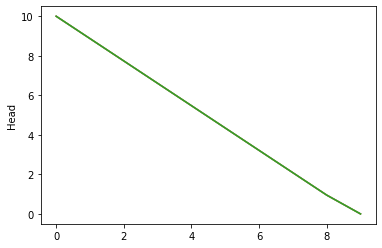

In [57]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
plot(h[20:30])
plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))


### Test Case 2 (single conduit, recharge boundary)

In [61]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=1.475

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10.)
    


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.321679065747
max change in h:  0.109701065067
max change in h:  0.0808589219849
max change in h:  0.0410133142662
max change in h:  0.0148137304748
max change in h:  0.00447814162762
max change in h:  0.00305681428719
max change in h:  0.00204206949273
max change in h:  0.00114771343805
max change in h:  0.000573343627334
max change in h:  0.000265256520835
max change in h:  0.000118107299547
max change in h:  5.23104733321e-05
average dh= 0.190625384196   average abs(dQ)= 0.175424135459
Time iteration: 1
max change in h:  0.161957322706
max change in h:  0.0737699080751
max change in h:  0.0493572683458
max change in h:  0.0266243234852
max change in h:  0.0111963317351
max change in h:  0.00385898916629
max change in h:  0.00234721650336
max change in h:  0.00147615904684
max change in h:  0.000852337601309
max change in h:  0.000463802321318
max cha

max change in h:  0.000747483448879
max change in h:  0.000367293096278
max change in h:  0.00018040714744
max change in h:  8.85821600107e-05
average dh= 0.063491365715   average abs(dQ)= 0.013862411272
Time iteration: 23
max change in h:  0.0249120311877
max change in h:  0.01229386531
max change in h:  0.00605708547214
max change in h:  0.00298108131309
max change in h:  0.00146604966999
max change in h:  0.000720552181983
max change in h:  0.000353981776009
max change in h:  0.000173838395591
max change in h:  8.53505803562e-05
average dh= 0.061081906958   average abs(dQ)= 0.0131567442832
Time iteration: 24
max change in h:  0.0240278885029
max change in h:  0.0118582979113
max change in h:  0.00584183322022
max change in h:  0.00287450025722
max change in h:  0.00141327420885
max change in h:  0.000694465570215
max change in h:  0.000341124922405
max change in h:  0.000167522231924
max change in h:  8.22563166292e-05
average dh= 0.058785896729   average abs(dQ)= 0.0125047707634
Ti

max change in h:  7.73739785869e-05
average dh= 0.0269328019127   average abs(dQ)= 0.00482179510201
Time iteration: 48
max change in h:  0.0106170579297
max change in h:  0.00524559195819
max change in h:  0.00258767329284
max change in h:  0.00127535803815
max change in h:  0.000628242909574
max change in h:  0.00030937911812
max change in h:  0.000152326978067
max change in h:  7.499225232e-05
average dh= 0.0261005653529   average abs(dQ)= 0.00465311862323
Time iteration: 49
max change in h:  0.0102875157545
max change in h:  0.00508302199833
max change in h:  0.00250761195998
max change in h:  0.00123596874608
max change in h:  0.000608874612663
max change in h:  0.000299858459156
max change in h:  0.00014764787301
max change in h:  7.26928715977e-05
average dh= 0.0252973280824   average abs(dQ)= 0.00449166819435
Time iteration: 50
max change in h:  0.00996955300336
max change in h:  0.00492614741924
max change in h:  0.00243034621358
max change in h:  0.00119795010965
max change in

max change in h:  0.000248238898999
max change in h:  0.000122374430653
max change in h:  6.0316437434e-05
average dh= 0.0103251517343   average abs(dQ)= 0.00170833296753
Time iteration: 80
max change in h:  0.00405917271975
max change in h:  0.00200730978345
max change in h:  0.000991195885797
max change in h:  0.000489028258976
max change in h:  0.000241151977164
max change in h:  0.000118882955178
max change in h:  5.85966186453e-05
average dh= 0.0100305805265   average abs(dQ)= 0.00165732434242
Time iteration: 81
max change in h:  0.00394318668212
max change in h:  0.00194998174288
max change in h:  0.000962903308301
max change in h:  0.000475077595564
max change in h:  0.000234276646534
max change in h:  0.000115495596225
max change in h:  5.6928022321e-05
average dh= 0.00974479292352   average abs(dQ)= 0.00160797015108
Time iteration: 82
max change in h:  0.00383066953711
max change in h:  0.00189436658879
max change in h:  0.000935455159288
max change in h:  0.000461542832927
ma

max change in h:  0.000347467943417
max change in h:  0.000171493354516
max change in h:  8.45996469163e-05
average dh= 0.00352186630787   average abs(dQ)= 0.000570848233985
Time iteration: 118
max change in h:  0.00138309504182
max change in h:  0.000684154828177
max change in h:  0.000337946317824
max change in h:  0.00016679484782
max change in h:  8.22822793793e-05
average dh= 0.00342541519973   average abs(dQ)= 0.000554989745461
Time iteration: 119
max change in h:  0.0013451976269
max change in h:  0.000665411679503
max change in h:  0.000328689571495
max change in h:  0.000162227000391
max change in h:  8.0029329089e-05
average dh= 0.00333164341049   average abs(dQ)= 0.00053957611541
Time iteration: 120
max change in h:  0.00130835453127
max change in h:  0.000647189817554
max change in h:  0.000319690183508
max change in h:  0.00015778609961
max change in h:  7.78389655114e-05
average dh= 0.0032404755104   average abs(dQ)= 0.000524599298126
Time iteration: 121
max change in h: 

Time iteration: 161
max change in h:  0.000426430286204
max change in h:  0.00021094932389
max change in h:  0.000104210935415
max change in h:  5.14396456772e-05
average dh= 0.00105726201465   average abs(dQ)= 0.000171621008103
Time iteration: 162
max change in h:  0.000415042128992
max change in h:  0.000205316027873
max change in h:  0.000101428183873
max change in h:  5.00661269491e-05
average dh= 0.00102903488356   average abs(dQ)= 0.000167018215265
Time iteration: 163
max change in h:  0.000403959538371
max change in h:  0.000199833869875
max change in h:  9.87200840399e-05
average dh= 0.00100235525426   average abs(dQ)= 0.000161569514465
Time iteration: 164
max change in h:  0.000393702000661
max change in h:  0.000194749687122
max change in h:  9.62056225493e-05
average dh= 0.000976957297079   average abs(dQ)= 0.000159854615198
Time iteration: 165
max change in h:  0.000383593676288
max change in h:  0.000189745485207
max change in h:  9.37324645545e-05
average dh= 0.0009519029

max change in h:  5.35439669349e-05
average dh= 0.000269135247925   average abs(dQ)= 4.55309176665e-05
Time iteration: 216
max change in h:  0.000105645316228
max change in h:  5.22500307056e-05
average dh= 0.000262631716609   average abs(dQ)= 4.44294420202e-05
Time iteration: 217
max change in h:  0.000103092350059
max change in h:  5.09874006767e-05
average dh= 0.00025628551992   average abs(dQ)= 4.33546726459e-05
Time iteration: 218
max change in h:  0.000100601149711
max change in h:  4.97553176899e-05
average dh= 0.000250092842877   average abs(dQ)= 4.23059591747e-05
Time iteration: 219
max change in h:  9.81702174645e-05
average dh= 0.000244683935834   average abs(dQ)= 3.84718771869e-05
Time iteration: 220
max change in h:  9.62599588838e-05
average dh= 0.000239942022381   average abs(dQ)= 3.94202169964e-05
Time iteration: 221
max change in h:  9.43179665445e-05
average dh= 0.000235148557195   average abs(dQ)= 3.94650342259e-05
Time iteration: 222
max change in h:  9.2383212122e-

max change in h:  1.90908470952e-05
average dh= 4.76007099513e-05   average abs(dQ)= 8.14106938557e-06
Time iteration: 298
max change in h:  1.86937437192e-05
average dh= 4.66105921944e-05   average abs(dQ)= 7.97169760752e-06
Time iteration: 299
max change in h:  1.83049021558e-05
average dh= 4.5641073559e-05   average abs(dQ)= 7.80585094526e-06
Time iteration: 300
max change in h:  1.79241504412e-05
average dh= 4.46917253135e-05   average abs(dQ)= 7.64345597309e-06
Time iteration: 301
max change in h:  1.75513201945e-05
average dh= 4.37621276566e-05   average abs(dQ)= 7.48444079765e-06
Time iteration: 302
max change in h:  1.71862465486e-05
average dh= 4.28518695311e-05   average abs(dQ)= 7.32873502449e-06
Time iteration: 303
max change in h:  1.68287680609e-05
average dh= 4.19605484414e-05   average abs(dQ)= 7.17626972815e-06
Time iteration: 304
max change in h:  1.64787266588e-05
average dh= 4.10877702749e-05   average abs(dQ)= 7.02697742033e-06
Time iteration: 305
max change in h: 

max change in h:  2.19113575817e-06
average dh= 5.46338744513e-06   average abs(dQ)= 9.34226375399e-07
Time iteration: 401
max change in h:  2.14556740374e-06
average dh= 5.34976726476e-06   average abs(dQ)= 9.14797149976e-07
Time iteration: 402
max change in h:  2.10094674813e-06
average dh= 5.23851005926e-06   average abs(dQ)= 8.95772014869e-07
Time iteration: 403
max change in h:  2.05725407199e-06
average dh= 5.12956668322e-06   average abs(dQ)= 8.77142565525e-07
Time iteration: 404
max change in h:  2.01447007875e-06
average dh= 5.02288901345e-06   average abs(dQ)= 8.58900571471e-07
Time iteration: 405
max change in h:  1.97257587153e-06
average dh= 4.91842992771e-06   average abs(dQ)= 8.41037973431e-07
Time iteration: 406
max change in h:  1.93155294248e-06
average dh= 4.81614328396e-06   average abs(dQ)= 8.23546880496e-07
Time iteration: 407
max change in h:  1.89138316919e-06
average dh= 4.7159838999e-06   average abs(dQ)= 8.06419565264e-07
Time iteration: 408
max change in h: 

Node net fluxes =  [  1.08785817e-06   1.04335798e-06   9.56177981e-07   8.29884453e-07
   6.69643590e-07   4.82010850e-07   2.74646442e-07   5.64118096e-08]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           8.70842856   7.59954891   6.49067078   5.38179405
   4.27291854   3.164044     2.05517017   0.94629674   0.
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [-1.47499891 -1.47499787 -1.47499691 -1.47499608 -1.47499541 -1.47499493
 -1.47499466 -1.4749946 ]
DW discharge =  1.47572957475


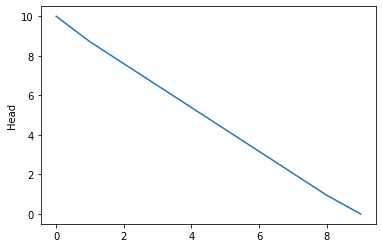

In [62]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
#plot(h[20:30])
#plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))


### Test Case 3 (Single conduit, Recharge boundary, tilted domain)

In [54]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.001*mg.node_x + 0.9
mg.at_node['hydraulic__head'] = mg.at_node['junction__elevation'] + 1
h = mg.at_node['hydraulic__head']


w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=0.1

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 1.1


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10.)



Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.0089975782931
max change in h:  0.004259473294
max change in h:  0.00198536855112
max change in h:  0.000908971643444
max change in h:  0.000409909385771
max change in h:  0.000206181349361
max change in h:  0.000116291524992
max change in h:  7.74303159781e-05
average dh= 0.0109514813923   average abs(dQ)= 0.0866585871867
Time iteration: 1
max change in h:  0.0120866825181
max change in h:  0.00465476242895
max change in h:  0.00228698369887
max change in h:  0.000954128186332
max change in h:  0.000513331356397
max change in h:  0.000236335675475
max change in h:  0.00011037243559
max change in h:  2.63313886077e-05
average dh= 0.00538113796495   average abs(dQ)= 0.0719380635214
Time iteration: 2
max change in h:  0.00839273015789
max change in h:  0.00331448921682
max change in h:  0.00164741254897
max change in h:  0.00074475431404
max change in h:

max change in h:  -0.000124929316004
average dh= -0.00200381438547   average abs(dQ)= 0.000546459684151
Time iteration: 53
max change in h:  -0.000122745835006
average dh= -0.00204907904555   average abs(dQ)= 0.000244587463006
Time iteration: 54
max change in h:  -0.000120586909224
average dh= -0.00205913458702   average abs(dQ)= 7.70800924127e-05
Time iteration: 55
max change in h:  -0.000118543333465
average dh= -0.0020373515479   average abs(dQ)= 0.000285399080015
Time iteration: 56
max change in h:  -0.000116529823022
average dh= -0.0019868199806   average abs(dQ)= 0.000508566477854
Time iteration: 57
max change in h:  -0.000113909131411
average dh= -0.0019103409749   average abs(dQ)= 0.000702061037735
Time iteration: 58
max change in h:  -0.000109743675464
average dh= -0.00181054252235   average abs(dQ)= 0.00086553709842
Time iteration: 59
max change in h:  -0.000103526683692
average dh= -0.00169012715201   average abs(dQ)= 0.00099930246782
Time iteration: 60
max change in h:  -9.

max change in h:  -1.56781571858e-06
average dh= -2.35825242251e-05   average abs(dQ)= 7.62392332373e-06
Time iteration: 151
max change in h:  -1.60606952382e-06
average dh= -2.44025865897e-05   average abs(dQ)= 4.10438415294e-06
Time iteration: 152
max change in h:  -1.58314432497e-06
average dh= -2.47505808626e-05   average abs(dQ)= 8.07751104429e-07
Time iteration: 153
max change in h:  -1.53740793296e-06
average dh= -2.46611257404e-05   average abs(dQ)= 2.22956479601e-06
Time iteration: 154
max change in h:  -1.50585927394e-06
average dh= -2.41771794349e-05   average abs(dQ)= 4.97869815857e-06
Time iteration: 155
max change in h:  -1.4752968851e-06
average dh= -2.33368979264e-05   average abs(dQ)= 7.41790483686e-06
Time iteration: 156
max change in h:  -1.39915133945e-06
average dh= -2.21717991579e-05   average abs(dQ)= 9.53222176593e-06
Time iteration: 157
max change in h:  -1.26089141839e-06
average dh= -2.07185696264e-05   average abs(dQ)= 1.13135176667e-05
Time iteration: 158
m

max change in h:  -1.05529411876e-08
average dh= -1.67617247586e-07   average abs(dQ)= 1.99575342738e-07
Time iteration: 263
max change in h:  -1.86337700825e-09
average dh= -1.41259736751e-07   average abs(dQ)= 2.0184483915e-07
Time iteration: 264
max change in h:  -6.65416566292e-09
average dh= -1.13063605377e-07   average abs(dQ)= 2.00568546027e-07
Time iteration: 265
max change in h:  2.01755323559e-09
average dh= -8.40692551637e-08   average abs(dQ)= 1.96048101236e-07
Time iteration: 266
max change in h:  5.34805288943e-09
average dh= -5.70652627756e-08   average abs(dQ)= 1.88665020984e-07
Time iteration: 267
max change in h:  5.14514608696e-09
average dh= -3.30096848596e-08   average abs(dQ)= 1.78787916151e-07
Time iteration: 268
max change in h:  1.44037930472e-08
average dh= -1.01391494416e-08   average abs(dQ)= 1.66719034364e-07
Time iteration: 269
max change in h:  1.48238639142e-08
average dh= 1.29475601173e-08   average abs(dQ)= 1.52775389459e-07
Time iteration: 270
max cha

max change in h:  3.82954468137e-09
average dh= -2.4387160371e-10   average abs(dQ)= 1.09054116692e-08
Time iteration: 370
max change in h:  5.59157076196e-09
average dh= -9.8429770716e-10   average abs(dQ)= 5.45818669949e-09
Time iteration: 371
max change in h:  1.6335670594e-09
average dh= -2.20749903669e-10   average abs(dQ)= 1.31426387325e-08
Time iteration: 372
max change in h:  4.1637353565e-09
average dh= 1.30409647324e-09   average abs(dQ)= 6.75874621027e-09
Time iteration: 373
max change in h:  3.57168605802e-09
average dh= 1.91712866242e-09   average abs(dQ)= 1.06685745689e-08
Time iteration: 374
max change in h:  3.04820479968e-09
average dh= 1.18728968327e-09   average abs(dQ)= 1.02968122188e-08
Time iteration: 375
max change in h:  5.25759125125e-09
average dh= 3.68411505816e-10   average abs(dQ)= 4.48763199518e-09
Time iteration: 376
max change in h:  1.60849555897e-09
average dh= 6.66265870496e-10   average abs(dQ)= 1.30606859147e-08
Time iteration: 377
max change in h: 

max change in h:  1.85699522426e-09
average dh= -4.33785996012e-10   average abs(dQ)= 2.29885023517e-09
Time iteration: 483
max change in h:  4.37697433853e-10
average dh= -6.38671056666e-11   average abs(dQ)= 4.68063883138e-09
Time iteration: 484
max change in h:  1.95170946071e-09
average dh= 4.02332748194e-10   average abs(dQ)= 9.00829098816e-10
Time iteration: 485
max change in h:  9.29431198671e-10
average dh= 3.6623279534e-10   average abs(dQ)= 4.09381497278e-09
Time iteration: 486
max change in h:  1.5263761366e-09
average dh= -1.12547904468e-10   average abs(dQ)= 3.4798037854e-09
Time iteration: 487
max change in h:  1.91456139831e-09
average dh= -4.10862690745e-10   average abs(dQ)= 1.91925142272e-09
Time iteration: 488
max change in h:  4.4663228671e-10
average dh= -1.59658049281e-10   average abs(dQ)= 4.5623916485e-09
Time iteration: 489
max change in h:  1.6413890247e-09
average dh= 2.93208558891e-10   average abs(dQ)= 1.62093617521e-09
Time iteration: 490
max change in h: 

Node net fluxes =  [ -5.79918752e-11   2.98513925e-10  -1.09041469e-09   2.92545151e-09
  -6.08022530e-09   9.60268054e-09  -1.11402348e-08   7.94067150e-09]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           1.1
  10.           1.20865089   1.1747188    1.15149993   1.13552482
   1.12425103   1.11603855   1.10986681   1.10509684   1.1
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           1.1       ]
Discharge= [-0.1        -0.1        -0.1        -0.1        -0.1        -0.09999999
 -0.10000001 -0.1       ]
D_H= [ 0.89946732  0.97406308  1.04897759  1.11934994  1.18317406  1.24014384
  1.29071314  1.        ]


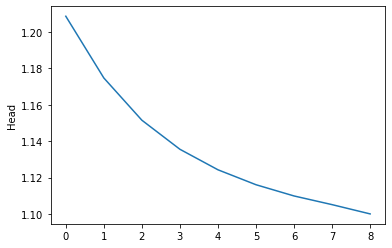

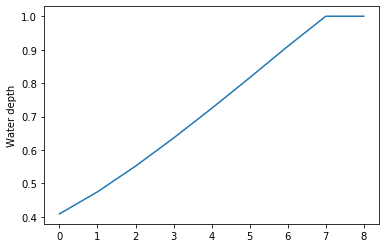

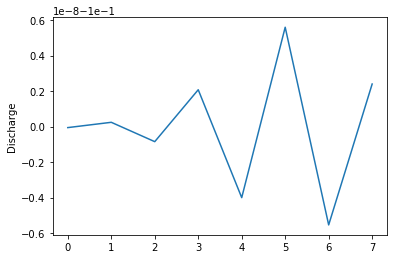

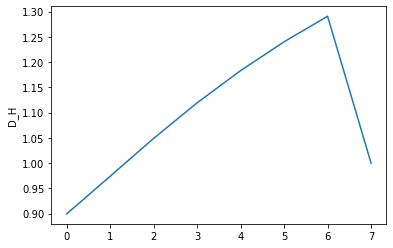

In [55]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",mg.at_node['hydraulic__head'])

figure()
plot(mg.at_node['hydraulic__head'][11:20])
ylabel('Head')

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')



print('Discharge=',Q[mg.active_links])
print('D_H=',mg.at_link['hydraulic__diameter'][mg.active_links])

Need to think about downstream bndy cond. It can produce some weird effects to have an artificially low fixed head boundary. 

For fully open channel solution iteration seems to get stuck with low dQ before head ever reaches appropriate range. 

In [53]:
mg.at_link['width']

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [13]:
mg = RasterModelGrid((5,5),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.


w = mg.add_zeros('link','width')
mg.at_link['width']= 0.5*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = w

mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= w#mg.at_link['hydraulic__diameter']#applicable for square conduits



#set heads at edges
h[mg.nodes_at_left_edge] = 4.2
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)


pfn = PresFlowNetwork(mg)


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9


In [8]:
mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes]

array([  1.50350309e-01,   1.95539803e-09,   8.41032719e-02,
         1.50350310e-01,  -5.00000011e-02,   8.41032727e-02,
         1.50350309e-01,   1.95539803e-09,   8.41032719e-02])

In [14]:
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=5.)

Time iteration: 0
max change in h:  0.00624999846719
max change in h:  0.00312499998806
max change in h:  0.00156250035591
max change in h:  0.000781250332019
max change in h:  0.000390625209346
max change in h:  0.000195312607906
max change in h:  0.000675557188024
max change in h:  0.00305957032746
max change in h:  0.0105381863919
max change in h:  0.00725064368962
max change in h:  0.0041586203004
max change in h:  0.00222711783631
max change in h:  0.00115316599532
max change in h:  0.000586228797804
max change in h:  0.000294910608406
max change in h:  0.000147451708341
max change in h:  7.34562679073e-05
average dh= 0.0129024910041   average abs(dQ)= 0.0202490671414
Time iteration: 1
max change in h:  0.0183385479768
max change in h:  0.00936328553833
max change in h:  0.00471649483183
max change in h:  0.00235976505261
max change in h:  0.00117653968185
max change in h:  0.000585544663148
max change in h:  0.000291141915632
max change in h:  0.0001446891683
max change in h:  7.

max change in h:  0.0184983326994
max change in h:  0.00919559514918
max change in h:  0.00456769356744
max change in h:  0.00226793248017
max change in h:  0.00112579906238
max change in h:  0.000558772058395
max change in h:  0.000277317196227
max change in h:  0.000137626259291
max change in h:  6.82992629502e-05
average dh= 0.0274201741593   average abs(dQ)= 0.000363688026154
Time iteration: 22
max change in h:  0.0182260564411
max change in h:  0.00905961690631
max change in h:  0.00449977504786
max change in h:  0.00223400000523
max change in h:  0.00110884240104
max change in h:  0.000550297149648
max change in h:  0.000273081035665
max change in h:  0.000135508722703
max change in h:  6.72407526761e-05
average dh= 0.0270571711375   average abs(dQ)= 0.000363688024317
Time iteration: 23
max change in h:  0.017953777736
max change in h:  0.00892363993199
max change in h:  0.00443185881075
max change in h:  0.00220006948946
max change in h:  0.0010918870733
max change in h:  0.0005

max change in h:  0.00809338137118
max change in h:  0.00411750453417
max change in h:  0.00208835173403
max change in h:  0.00105566110129
max change in h:  0.000531928454135
max change in h:  0.000267263253926
max change in h:  0.000133959554679
max change in h:  6.70126384379e-05
average dh= 0.0189583344026   average abs(dQ)= 0.00149362829947
Time iteration: 47
max change in h:  0.0167009789123
max change in h:  0.00841779637088
max change in h:  0.00423573607795
max change in h:  0.00212756156216
max change in h:  0.00106682858301
max change in h:  0.000534134137212
max change in h:  0.000267087661617
max change in h:  0.000133417672519
max change in h:  6.65933123611e-05
average dh= 0.0188782200975   average abs(dQ)= 0.000835213844493
Time iteration: 48
max change in h:  0.0170961042849
max change in h:  0.00856004318594
max change in h:  0.00428063031827
max change in h:  0.00213854453726
max change in h:  0.00106762399607
max change in h:  0.000532721048491
max change in h:  0.0

max change in h:  0.00197335638244
max change in h:  0.000981202940764
max change in h:  0.000487874491107
max change in h:  0.000242602055053
max change in h:  0.000120652975254
max change in h:  6.00127743486e-05
average dh= 0.018540875862   average abs(dQ)= 0.000324949259626
Time iteration: 74
max change in h:  0.0158303487253
max change in h:  0.00787765926414
max change in h:  0.0039170311272
max change in h:  0.00194675227653
max change in h:  0.000967310682696
max change in h:  0.000480616924621
max change in h:  0.000238813297536
max change in h:  0.00011867811769
max change in h:  5.89854876971e-05
average dh= 0.0185281508888   average abs(dQ)= 0.000356951245745
Time iteration: 75
max change in h:  0.0156199210276
max change in h:  0.00776872837308
max change in h:  0.00386030470262
max change in h:  0.00191709092601
max change in h:  0.000951766643717
max change in h:  0.000472466031704
max change in h:  0.000234541966578
max change in h:  0.000116443300198
max change in h:  

max change in h:  5.93162757923e-05
average dh= 0.0112965344445   average abs(dQ)= 0.0031008012989
Time iteration: 101
max change in h:  0.00788653313485
max change in h:  0.00345062272935
max change in h:  0.00146373010342
max change in h:  0.000601939481848
max change in h:  0.000239634136575
max change in h:  9.20534526063e-05
average dh= 0.00863111011192   average abs(dQ)= 0.00300583354836
Time iteration: 102
max change in h:  0.00510978563831
max change in h:  0.00217299932469
max change in h:  0.000892720495965
max change in h:  0.000353770796111
max change in h:  0.000134713387288
max change in h:  5.77774384496e-05
average dh= 0.0062061517375   average abs(dQ)= 0.00266602664652
Time iteration: 103
max change in h:  0.00289822928991
max change in h:  0.00119335890272
max change in h:  0.000501359007439
max change in h:  0.000238632381114
max change in h:  0.000112354555527
max change in h:  5.23530263714e-05
average dh= 0.00422642037678   average abs(dQ)= 0.00216484174945
Time i

max change in h:  6.66539023975e-09
average dh= -1.40756159486e-11   average abs(dQ)= 6.70322998081e-09
Time iteration: 194
max change in h:  5.98917537786e-09
average dh= -5.32152298886e-12   average abs(dQ)= 6.36514941825e-09
Time iteration: 195
max change in h:  5.03246155859e-09
average dh= 1.95808481505e-12   average abs(dQ)= 5.82461405444e-09
Time iteration: 196
max change in h:  3.92255894432e-09
average dh= 7.55877479628e-12   average abs(dQ)= 5.41223694044e-09
Time iteration: 197
max change in h:  2.77059353238e-09
average dh= 1.14392039061e-11   average abs(dQ)= 4.79003887708e-09
Time iteration: 198
max change in h:  1.66707270211e-09
average dh= 1.36891937359e-11   average abs(dQ)= 3.96091431236e-09
Time iteration: 199
max change in h:  6.7985284069e-10
average dh= 1.44953188467e-11   average abs(dQ)= 3.02752963733e-09
Time iteration: 200
max change in h:  4.41311431842e-10
average dh= 1.41069788287e-11   average abs(dQ)= 2.07812201725e-09
Time iteration: 201
max change in h

max change in h:  5.72875080707e-14
average dh= -1.36293368566e-16   average abs(dQ)= 5.50119785277e-14
Time iteration: 291
max change in h:  5.48450174165e-14
average dh= -7.3058842926e-17   average abs(dQ)= 5.52654333731e-14
Time iteration: 292
max change in h:  4.90718576884e-14
average dh= -2.50426608463e-17   average abs(dQ)= 5.23801379874e-14
Time iteration: 293
max change in h:  4.10782519111e-14
average dh= 1.6928973655e-17   average abs(dQ)= 4.7760218511e-14
Time iteration: 294
max change in h:  3.19744231092e-14
average dh= 5.34034622079e-17   average abs(dQ)= 4.44223982203e-14
Time iteration: 295
max change in h:  2.24265050974e-14
average dh= 8.06415119866e-17   average abs(dQ)= 3.9172435309e-14
Time iteration: 296
max change in h:  1.33226762955e-14
average dh= 9.54367757661e-17   average abs(dQ)= 3.22724793214e-14
Time iteration: 297
max change in h:  5.3290705182e-15
average dh= 1.04687670569e-16   average abs(dQ)= 2.45383908866e-14
Time iteration: 298
max change in h:  

max change in h:  0.0
average dh= -3.92914867309e-17   average abs(dQ)= 9.82859386085e-18
Time iteration: 394
max change in h:  0.0
average dh= -3.90206771216e-17   average abs(dQ)= 9.81955884275e-18
Time iteration: 395
max change in h:  0.0
average dh= -3.92452274382e-17   average abs(dQ)= 9.76836040682e-18
Time iteration: 396
max change in h:  0.0
average dh= -3.89927287989e-17   average abs(dQ)= 9.76083122507e-18
Time iteration: 397
max change in h:  0.0
average dh= -3.82448702337e-17   average abs(dQ)= 9.75781955237e-18
Time iteration: 398
max change in h:  0.0
average dh= -3.89763452994e-17   average abs(dQ)= 9.72920866171e-18
Time iteration: 399
max change in h:  0.0
average dh= -3.97232401293e-17   average abs(dQ)= 9.7231853163e-18
Time iteration: 400
max change in h:  0.0
average dh= -3.94697777548e-17   average abs(dQ)= 9.71866780725e-18
Time iteration: 401
max change in h:  0.0
average dh= -3.87238466601e-17   average abs(dQ)= 9.71264446185e-18
Time iteration: 402
max change 

In [10]:
#h_new_solver = h.copy()
#Q_new_solver = Q.copy()
#h[mg.core_nodes]
#mg.at_link['hydraulic__diameter']
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])

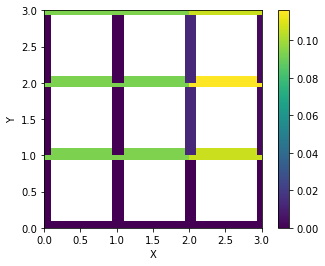

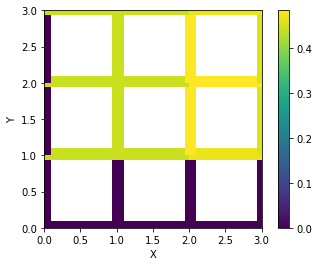

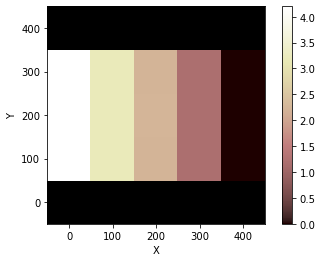

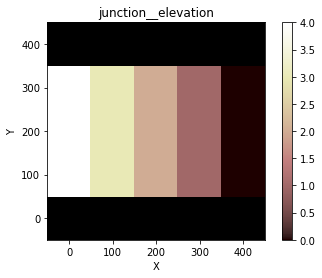

In [15]:
figure()
plot_links(mg, 'conduit__discharge',magnitude=True)
figure()
plot_links(mg, 'hydraulic__diameter')
figure()
imshow_grid_at_node(mg, h)
figure()
imshow_grid_at_node(mg, 'junction__elevation')


In [9]:
FUDGE=0.0001
active_links = mg.active_links
head_nodes = mg.node_at_link_head[active_links]
tail_nodes = mg.node_at_link_tail[active_links]
h_head = mg.at_node['hydraulic__head'][head_nodes]
h_tail = mg.at_node['hydraulic__head'][tail_nodes]
#Calculate flow depths using offset and junction elevations
y_head = h_head - mg.at_node['junction__elevation'][head_nodes] \
         - mg.at_link['conduit_head__offset'][active_links]
y_tail = h_tail - mg.at_node['junction__elevation'][tail_nodes] \
          - mg.at_link['conduit_tail__offset'][active_links]
y_head[y_head>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_head>mg.at_link['maximum__depth'][active_links]]
y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
y_avg = 0.5*(y_head + y_tail)
A_avg = mg.at_link['width'][active_links] * y_avg
y_avg[y_avg<FUDGE] = FUDGE
A_avg[A_avg<FUDGE] = FUDGE

In [10]:
h_head>h_tail

array([False, False, False, False, False, False, False, False, False], dtype=bool)

In [22]:
#y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = 
#mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
d_h_square(mg.at_link['width'][active_links], y_avg)

array([  3.96936126e-01,   3.53636005e-04,   3.99594057e-04,
         3.99687423e-04,   3.99814040e-04,   3.99715864e-04,
         3.99694894e-04,   4.90132384e-01,   3.99793756e-04,
         3.96927434e-04,   3.99777355e-04,   3.99802869e-04,
         3.99787176e-04,   3.97200621e-04,   2.81319838e-01,
         3.99646193e-04,   3.99446218e-04,   3.99054260e-04])

In [21]:
def d_h_square(width, flow_depth):
    d_H = np.zeros(np.size(width))
    is_full_pipe = np.isclose(width,flow_depth)
    d_H[is_full_pipe] = width[is_full_pipe]
    d_H[~is_full_pipe] = 4.*width[~is_full_pipe]*flow_depth[~is_full_pipe] / (2.*flow_depth[~is_full_pipe] + width[~is_full_pipe])
    return d_H

In [17]:
mg.at_link['hydraulic__diameter'][mg.active_links]

array([ 0.75,  0.75,  0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,
        0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.5 ])

In [11]:
pfn.run_one_step()

Number of iterations = 1 tolerance = nan  iteration time= 0.016219377517700195


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:186: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:267: RuntimeWarning: divide by zero encountered in double_scalars
  ADA_ij[i][j] = -1./(a[this_link]*r[this_link]*np.fabs(self.Q[this_link])**(a[this_link]-1))
/home/mcoving/anaconda3/envs/landlab_dev/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:277: RuntimeWarning: divide by zero encountered in true_divide
  dQ= -(1./a[self.grid.active_links])*self.Q[self.grid.active_links] - 1./(a[self.grid.active_links]*r[self.grid.active_links]*np.fabs(self.Q[self.grid.active_links])**(a[self.grid.active_link

In [5]:
d_h.copy()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [54]:
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])